In [ ]:
import jax
import neos.models as models
from neos.cls import cls_maker
import numpy as np
import jax.experimental.stax as stax
import jax.experimental.optimizers as optimizers
import jax.random
import time

In [ ]:
init_random_params, predict = stax.serial(
    stax.Dense(1024),
    stax.Relu,
    stax.Dense(1024),
    stax.Relu,
    stax.Dense(2),
    stax.Softmax,
)

In [ ]:
def get_hists(network, s, b1, b2):
    NMC = len(s)
    LUMI = 10
    sh, bh1, bh2 = (
        predict(network, s).sum(axis=0) * 2 / NMC * LUMI,
        predict(network, b1).sum(axis=0) * 10 / NMC * LUMI,
        predict(network, b2).sum(axis=0) * 10 / NMC * LUMI,
    )
    b_mean = jax.numpy.mean(jax.numpy.asarray([bh1, bh2]), axis=0)
    b_unc = jax.numpy.std(jax.numpy.asarray([bh1, bh2]), axis=0)
    results = sh, b_mean, b_unc
    return results


def hist_maker():
    NMC = 500
    bkg1 = np.random.multivariate_normal([2, 2], [[1, 0], [0, 1]], size=(NMC,))
    bkg2 = np.random.multivariate_normal([-1, -1], [[1, 0], [0, 1]], size=(NMC,))
    sig = np.random.multivariate_normal([-1, 1], [[1, 0], [0, 1]], size=(NMC,))

    def make(network):
        return get_hists(network, sig, bkg1, bkg2)

    make.bkg1 = bkg1
    make.bkg2 = bkg2
    make.sig = sig
    return make


def makeNN():
    hm = hist_maker()

    def nn_model_maker(network):
        s, b, db = hm(network)
        m = models.hepdata_like(s, b, db)
        nompars = m.config.suggested_init
        bonlypars = jax.numpy.asarray([x for x in nompars])
        bonlypars = jax.ops.index_update(bonlypars, m.config.poi_index, 0.0)
        return m, bonlypars

    nn_model_maker.hm = hm
    return nn_model_maker

In [ ]:
nnm = makeNN()
loss = cls_maker(nnm, solver_kwargs=dict(pdf_transform=True))

In [ ]:
_, network = init_random_params(jax.random.PRNGKey(2), (-1, 2))
jitted= jax.value_and_grad(jax.jit(loss))(network, 1.0)
normal = jax.value_and_grad(loss)(network, 1.0)
print(jitted[0],normal[0])

/home/phinate/envs/neos/lib/python3.7/site-packages/jax-0.1.59-py3.7.egg/jax/lib/xla_bridge.py:122: UserWarning: No GPU/TPU found, falling back to CPU.


exp_data: Traced<ShapedArray(float64[2,2])>with<JVPTrace(level=1/1)>
exp_data: Traced<ConcreteArray([[ 49.39805616  50.60194384]
 [820.6474071  861.13508311]])>with<JVPTrace(level=1/0)>
0.06603790998348469 0.06603790998345871


In [ ]:
#jit_loss = jax.jit(loss)

opt_init, opt_update, opt_params = optimizers.adam(1e-3)

#@jax.jit
def update_and_value(i, opt_state, mu):
    net = opt_params(opt_state)
    value, grad = jax.value_and_grad(loss)(net, mu)
    return opt_update(i, grad, state), value, net

def train_network(N):
    cls_vals = []
    _, network = init_random_params(jax.random.PRNGKey(1), (-1, 2))
    state = opt_init(network)
    losses = []
    
    # parameter update function
    #@jax.jit
    def update_and_value(i, opt_state, mu):
        net = opt_params(opt_state)
        value, grad = jax.value_and_grad(loss)(net, mu)
        return opt_update(i, grad, state), value, net
    
    for i in range(N):
        start_time = time.time()
        state, value, network = update_and_value(i,state,1.0)
        epoch_time = time.time() - start_time
        losses.append(value)
        metrics = {"loss": losses}
        yield network, metrics, epoch_time

In [ ]:
def plot(axarr, network, metrics, hm, maxN):
    ax = axarr[0]
    g = np.mgrid[-5:5:101j, -5:5:101j]
    levels = np.linspace(0, 1, 21)
    ax.contourf(
        g[0],
        g[1],
        predict(network, np.moveaxis(g, 0, -1)).reshape(101, 101, 2)[:, :, 0],
        levels=levels,
        cmap="BrBG",
    )
    ax.contour(
        g[0],
        g[1],
        predict(network, np.moveaxis(g, 0, -1)).reshape(101, 101, 2)[:, :, 0],
        colors="w",
        levels=levels,
    )
    ax.scatter(hm.sig[:, 0], hm.sig[:, 1], alpha=0.25, c="C9", label="sig")
    ax.scatter(hm.bkg1[:, 0], hm.bkg1[:, 1], alpha=0.17, c="C1", label="bkg1")
    ax.scatter(hm.bkg2[:, 0], hm.bkg2[:, 1], alpha=0.17, c="C1", label="bkg2")
    ax.set_xlim(-5, 5)
    ax.set_ylim(-5, 5)
    ax.set_xlabel("x")
    ax.set_ylabel("y")

    ax = axarr[1]
    ax.axhline(0.05, c="slategray", linestyle="--")
    ax.plot(metrics["loss"], c="steelblue", linewidth=2.0)

    ax.set_ylim(0, 0.6)
    ax.set_xlim(0, maxN)
    ax.set_xlabel("epoch")
    ax.set_ylabel(r"$cl_s$")

    ax = axarr[2]
    s, b, db = hm(network)
    ax.bar([0, 1], b, color="C1", label="bkg")
    ax.bar([0, 1], s, bottom=b, color="C9", label="sig")
    ax.bar([0, 1], db, bottom=b - db / 2.0, alpha=0.4, color="black", label="bkg error")
    ax.set_ylim(0, 100)
    ax.set_ylabel("frequency")
    ax.set_xlabel("nn output")

exp_data: Traced<ConcreteArray([[ 49.98113212  50.01886788]
 [756.69421668 757.83725659]])>with<JVPTrace(level=1/0)>
epoch 0: CLs = 0.06673359202068685, took 2.8126087188720703s
exp_data: Traced<ConcreteArray([[43.42374501 56.57625499]
 [ 3.79631781  6.4443097 ]])>with<JVPTrace(level=1/0)>
epoch 1: CLs = 0.4828998648892404, took 2.4825093746185303s
exp_data: Traced<ConcreteArray([[41.60433824 58.39566176]
 [ 3.99722519  7.87485466]])>with<JVPTrace(level=1/0)>
epoch 2: CLs = 0.3363519604174514, took 2.537659168243408s
exp_data: Traced<ConcreteArray([[38.94604261 61.05395739]
 [ 5.04205722 12.39106797]])>with<JVPTrace(level=1/0)>
epoch 3: CLs = 0.1834168537823735, took 2.5057926177978516s
exp_data: Traced<ConcreteArray([[36.07944815 63.92055185]
 [ 7.36571872 23.11939097]])>with<JVPTrace(level=1/0)>


KeyboardInterrupt: 

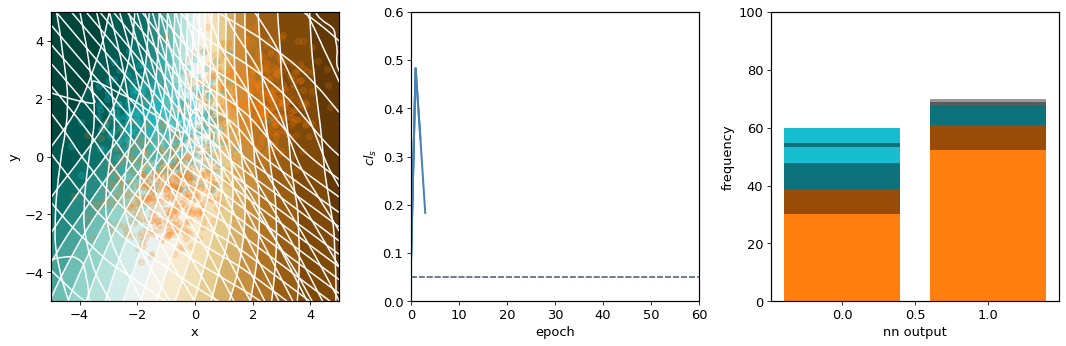

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from celluloid import Camera
from IPython.display import HTML

plt.rcParams.update(
    {
        "axes.labelsize": 13,
        "axes.linewidth": 1.2,
        "xtick.labelsize": 13,
        "ytick.labelsize": 13,
        "figure.figsize": [7.2, 3.0],
        "font.size": 13,
        "xtick.major.size": 4,
        "ytick.major.size": 4,
        "legend.fontsize": 11,
    }
)


fig, axarr = plt.subplots(1, 3)
fig.set_size_inches(15, 5)
camera = Camera(fig)
maxN = 60



for i, (network, metrics, epoch_time) in enumerate(train_network(maxN)):
    print(f"epoch {i}:", f'CLs = {metrics["loss"][-1]}, took {epoch_time}s')
    plot(axarr, network, metrics, nnm.hm, maxN=maxN)
    plt.tight_layout()
    camera.snap()
    if i % 10 == 0:
        camera.animate().save("animation.gif", writer="imagemagick", fps=8)
        HTML(camera.animate().to_html5_video())
camera.animate().save("animation.gif", writer="imagemagick", fps=8)